Idea 

$h_{3,2}$ and $h_{2,2}$ and then we (analytically?) solve for the $h_{3,2}^{spheroidal}$ data. This means we have no free coefficients in a traditional ringdown model but instead let the GPR model the complex strain / amp+phase and then we basically just extrapolate this using perturbation theory ansatz.


# imports

In [772]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


In [773]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [774]:
import lmfit

In [775]:
import waveform_utils
import waveform_generator
import hybrid_utils

In [776]:
import spliced_pn

In [777]:
import lalsimulation as lalsim

In [778]:
import numpy as np
import copy

In [779]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [780]:
import ringdown_fit
import qnm_utils as qu

In [781]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [782]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# single test case

In [783]:
def generate_example_case(q):
    approximant = lalsim.NRHybSur3dq8
    modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5)]
    f_min = 20
    phiRef = 0
    f_ref = 0
    deltaT=1/2048/6
    wf_ = waveform_generator.generate_waveform(q, modes, f_min=f_min, approximant=approximant, deltaT=deltaT, phiRef=phiRef, f_ref=f_ref)
    wf_ = waveform_utils.Waveform(wf_['t'], wf_['hlm'])
    (
        wf_
        .mask(end_time=100)
        .compute_amplitude()
        .compute_phase()
        .compute_frequency()
    )
    return wf_

In [784]:
q = 1
# q = 3
# q = 5
# q = 6
# q = 8

In [785]:
wf = generate_example_case(q)

In [786]:
wf

In [787]:
wf.times

array([-4836.19060039, -4835.86015533, -4835.52971027, ...,
          99.33678303,    99.66722809,    99.99767315])

In [788]:
wf.hlms[2,2]

array([9.29204881e-02-0.j        , 9.29170921e-02-0.00095024j,
       9.29039783e-02-0.00190044j, ..., 9.03900342e-05+0.00023391j,
       1.32987249e-04+0.0001997j , 1.65671295e-04+0.00015722j])

(-300.0, 100.0)

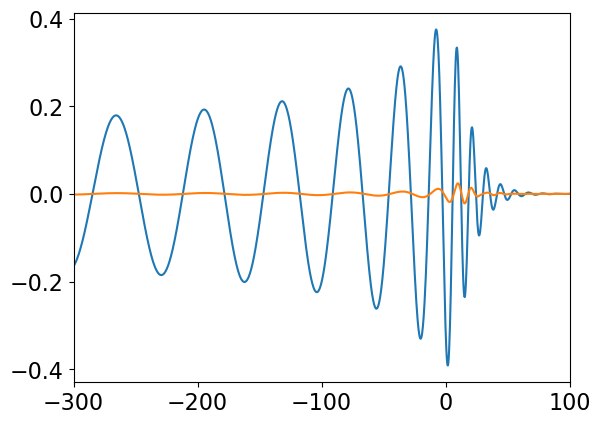

In [789]:
plt.figure()
plt.plot(wf.times, wf.hlms[2,2].real)
plt.plot(wf.times, wf.hlms[3,2].real)
plt.xlim(-300, 100)

In [790]:
def fit_merger(wf, l, m, t_merger_start, t_merger_end):
    
    x = wf.times.copy()
    y = wf.hlms[l,m].copy()

    mask = (x >= t_merger_start) & (x <= t_merger_end)
    x = x[mask]
    y = y[mask]

    kernel = RBF() #+ WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-16, 1))
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_targets=2,
        # alpha=1e-8,
        alpha=1e-3,
    ).fit(x[:,np.newaxis], np.column_stack([y.real, y.imag]))
    return gpr

In [791]:
t_merger_start = -300
t_merger_end = 100

In [792]:
gprs = {}
for mode in wf.modes:
    gprs[mode] = fit_merger(wf, mode[0], mode[1],t_merger_start,t_merger_end)

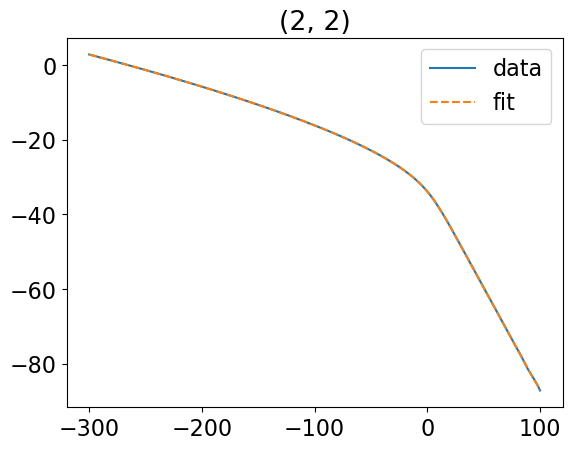

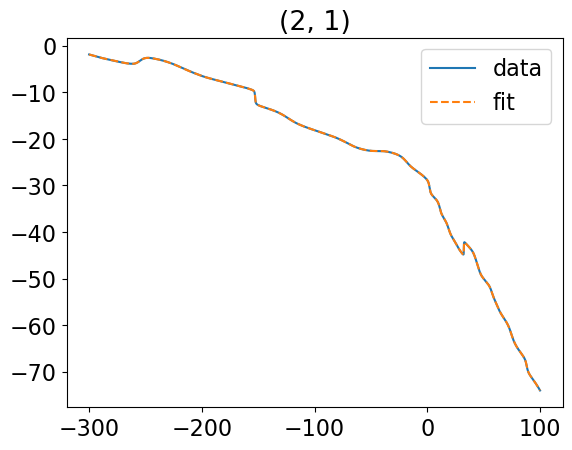

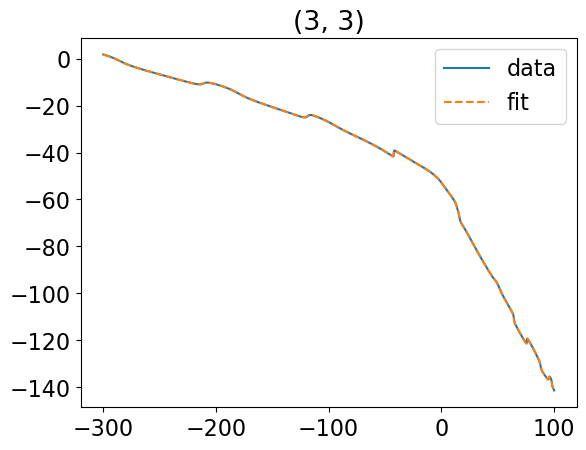

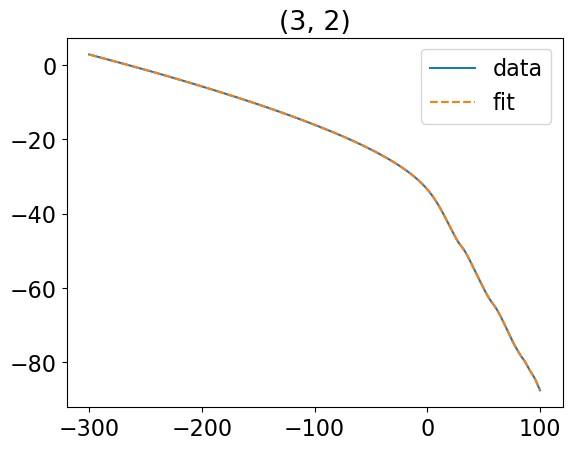

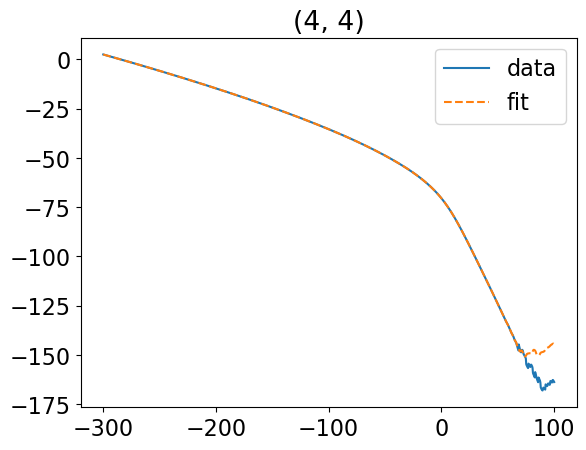

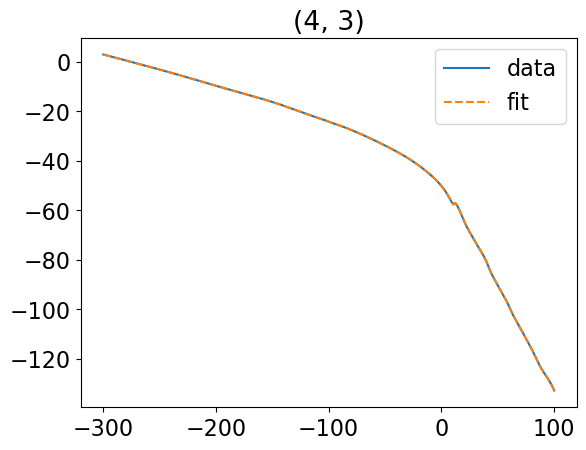

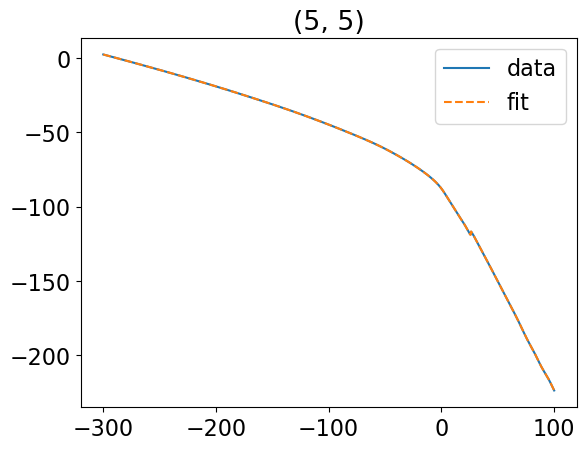

In [793]:
mask = (wf.times >= t_merger_start) & (wf.times <= t_merger_end)
t_ = wf.times[mask]
for mode in wf.modes:
    y_z = wf.hlms[mode]
    y_re = y_z.real[mask]
    y_amp = np.abs(y_z)[mask]
    y_phase = np.unwrap(np.angle(y_z[mask]))
    
    plt.figure()
    # plt.plot(t_, y_re, label='data')
    # plt.plot(t_, y_amp, label='data')
    plt.plot(t_, y_phase, label='data')
    
    yhat_re, yhat_im = gprs[mode].predict(t_[:,np.newaxis]).T
    yhat_z = yhat_re + 1.j * yhat_im
    yhat_amp = np.abs(yhat_z)
    yhat_phase = np.unwrap(np.angle(yhat_z))
    # plt.plot(t_, yhat_re, ls='--', label='fit')
    # plt.plot(t_, yhat_amp, ls='--', label='fit')
    plt.plot(t_, yhat_phase, ls='--', label='fit')

    
    plt.title(mode)
    plt.legend()
    plt.show()
    plt.close()

# compute spherioid modes

using gpr fit of spherical h22 and spherical 32 as well as
the mixing coefficient

In [794]:
lp=3
l=2
m=2
s_mixing = qu.get_mixing_coefficient(q, lp, l, m)

In [795]:
s_mixing

(0.0682728886122664-0.010546980594183209j)

In [796]:
# t_ = np.linspace(-300, 100, 100)

In [797]:
# yhat32_re, yhat32_im = gprs[3,2].predict(t_[:,np.newaxis]).T
# yhat32_z = yhat32_re + 1.j*yhat32_im

# yhat22_re, yhat22_im = gprs[2,2].predict(t_[:,np.newaxis]).T
# yhat22_z = yhat22_re + 1.j*yhat22_im

n_samples = 100

yhat32_re, yhat32_im = gprs[3,2].sample_y(t_[:,np.newaxis], n_samples).transpose(1,0,2)
yhat32_z = yhat32_re + 1.j*yhat32_im

yhat22_re, yhat22_im = gprs[2,2].sample_y(t_[:,np.newaxis], n_samples).transpose(1,0,2)
yhat22_z = yhat22_re + 1.j*yhat22_im

In [798]:
yhat32_z_spheroidal = yhat32_z - s_mixing * yhat22_z

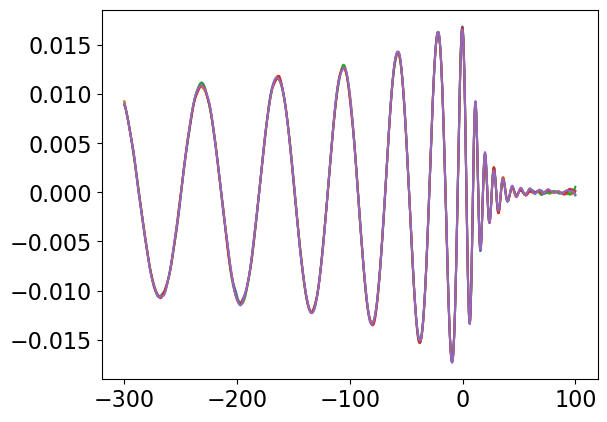

In [799]:
plt.plot(t_, yhat32_z_spheroidal.real[:,:5])

In [800]:
qu.get_angular_ringdown_frequency_from_bbh(q, 3, 2)

-0.7920271611270558

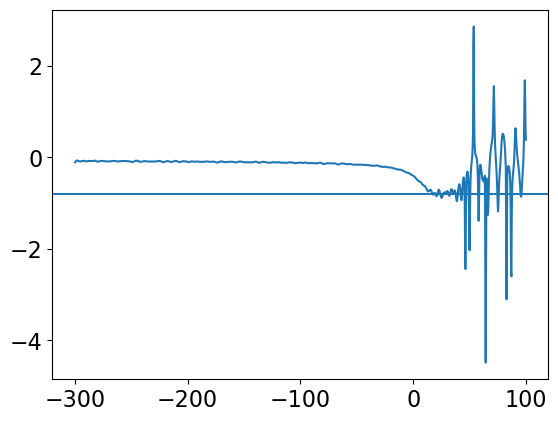

In [801]:
plt.plot(t_, IUS(t_, np.unwrap(np.angle(yhat32_z_spheroidal[:,0]))).derivative()(t_))
plt.axhline(qu.get_angular_ringdown_frequency_from_bbh(q, 3, 2))

# need to compare this with the other method

In [802]:
fr_22 = ringdown_fit.fit_lm_mode(wf=wf, l=l, m=m, q=q, start_time=30, end_time=90, n_tries=10)

In [803]:
fr_22

<Axes: title={'center': ' '}, xlabel='x', ylabel='y'>

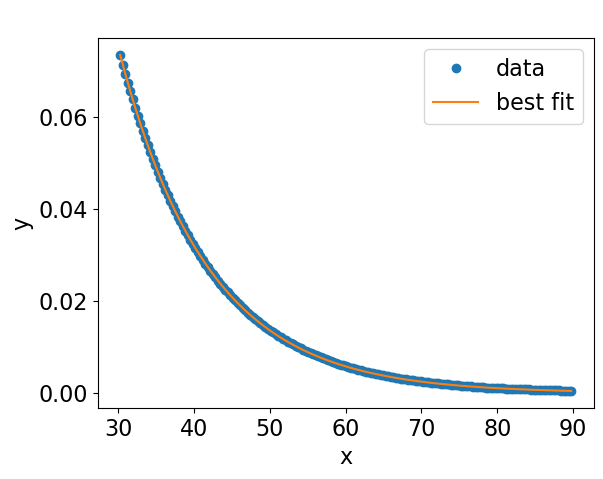

In [804]:
fr_22.plot_fit(title=' ')

<Axes: title={'center': ' '}, xlabel='x', ylabel='y'>

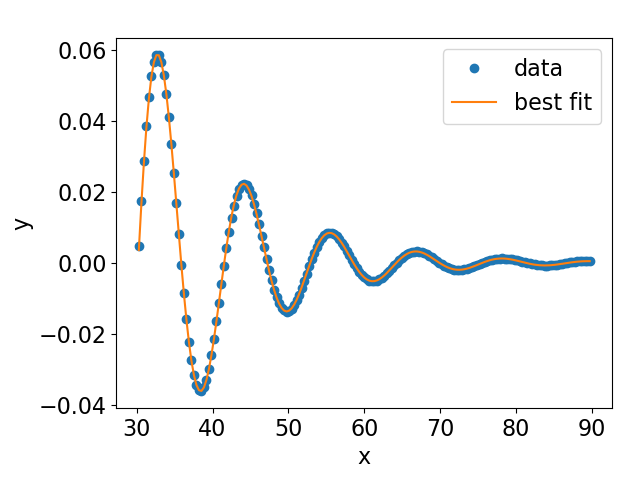

In [805]:
fr_22.plot_fit(parse_complex='real', title=' ')

In [806]:
fr_32 = ringdown_fit.fit_lm_mixed_mode(fit_result_lm_mode=fr_22, wf=wf, lp=lp, l=l, m=m, q=q, start_time=30, end_time=90, n_tries=10)

In [807]:
fr_32

<Axes: title={'center': ' '}, xlabel='x', ylabel='y'>

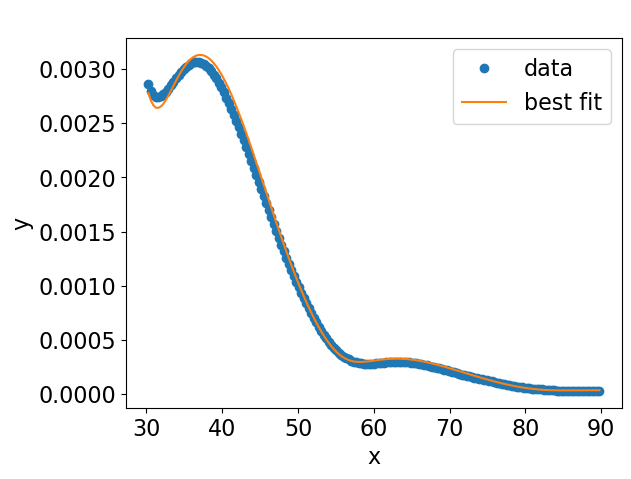

In [808]:
fr_32.plot_fit(title=' ')

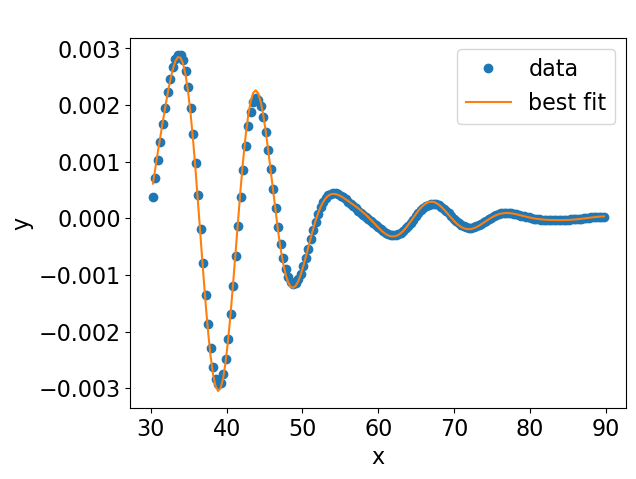

In [809]:
fr_32.plot_fit(parse_complex='real', title=' ');

In [810]:
fr_32_copy = copy.deepcopy(fr_32)

In [811]:
yhat32_z_spheroidal_amp = np.abs(yhat32_z_spheroidal)
yhat32_z_spheroidal_phase = np.unwrap(np.angle(yhat32_z_spheroidal))

# iamp = IUS(t_, yhat32_z_spheroidal_amp)
# iphase = IUS(t_, yhat32_z_spheroidal_phase)

iamp = [IUS(t_, yhat32_z_spheroidal_amp[:,i]) for i in range(n_samples)]
iphase = [IUS(t_, yhat32_z_spheroidal_phase[:,i]) for i in range(n_samples)]

In [812]:
# iamp(30)

In [813]:
# np.mod(iphase(30), 2*np.pi)

In [814]:
# np.mod(-1.5321202, 2*np.pi)

In [815]:
# float(iamp(30))

In [816]:
# np.mod(iphase(30), 2*np.pi)

In [817]:
np.mod(np.mean([np.mod(iphase[i](30), 2*np.pi) for i in range(n_samples)]), 2*np.pi)

4.59744420421161

In [818]:
new_32_preds = []
for i in range(n_samples):
    # fr_32_copy.params.set(phi0=np.mod(iphase(30), 2*np.pi), amp=float(iamp(30)))
    fr_32_copy.params.set(phi0={'value':np.mod(iphase[i](30), 2*np.pi), 'min':-10, 'max':10})
    fr_32_copy.params.set(amp=float(iamp[i](30)))
    new_32_preds.append(fr_32_copy.eval(fr_32_copy.params))
new_32_preds = np.array(new_32_preds)

In [819]:
fr_32_copy.params

Parameters([('t0', <Parameter 't0', value=30 (fixed), bounds=[-30:50]>), ('phi0', <Parameter 'phi0', value=4.516443153741136 +/- 0.0068, bounds=[-10:10]>), ('amp', <Parameter 'amp', value=0.002164152905723624 +/- 1.6e-05, bounds=[1e-08:inf]>), ('omega', <Parameter 'omega', value=-0.7920271611270558 (fixed), bounds=[-inf:inf]>), ('decay', <Parameter 'decay', value=0.08900596729104109 (fixed), bounds=[-inf:inf]>), ('p', <Parameter 'p', value=0.0690827483465808 (fixed), bounds=[1e-06:1]>), ('zeta', <Parameter 'zeta', value=-0.15327110323040896 (fixed), bounds=[-3.141592653589793:3.141592653589793]>)])

In [820]:
fr_32.params['phi0'].value

-1.5321202719609746

In [821]:
np.mod(fr_32.params['phi0'].value, 2*np.pi)

4.751065035218612

In [822]:
fr_32.params

Parameters([('t0', <Parameter 't0', value=30 (fixed), bounds=[-30:50]>), ('phi0', <Parameter 'phi0', value=-1.5321202719609746 +/- 0.0068, bounds=[-3.141592653589793:3.141592653589793]>), ('amp', <Parameter 'amp', value=0.002349640599337177 +/- 1.6e-05, bounds=[1e-08:inf]>), ('omega', <Parameter 'omega', value=-0.7920271611270558 (fixed), bounds=[-inf:inf]>), ('decay', <Parameter 'decay', value=0.08900596729104109 (fixed), bounds=[-inf:inf]>), ('p', <Parameter 'p', value=0.0690827483465808 (fixed), bounds=[1e-06:1]>), ('zeta', <Parameter 'zeta', value=-0.15327110323040896 (fixed), bounds=[-3.141592653589793:3.141592653589793]>)])

In [823]:
np.array(new_32_preds).shape

(100, 181)

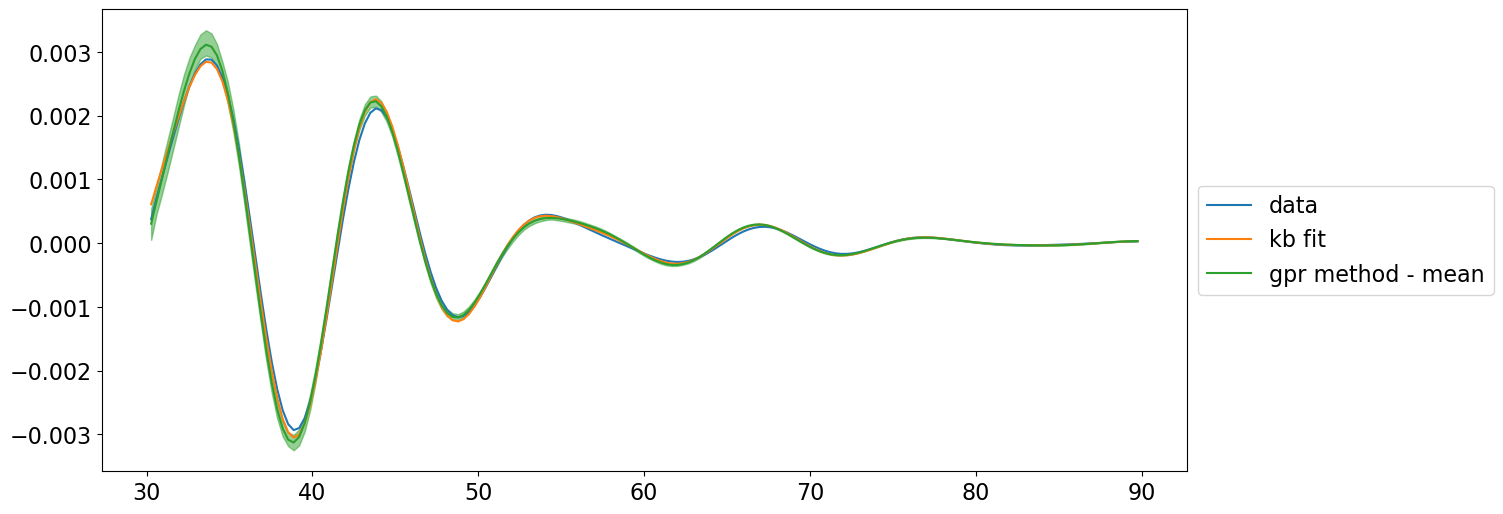

In [824]:
plt.figure(figsize=(14,6))
plt.plot(fr_32.userkws['x'], fr_32.data.real, label='data')
plt.plot(fr_32.userkws['x'], fr_32.eval().real, label='kb fit')
plt.plot(fr_32_copy.userkws['x'], new_32_preds.real.T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=new_32_preds.real.T.min(1), y2=new_32_preds.real.T.max(1), color='C2', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

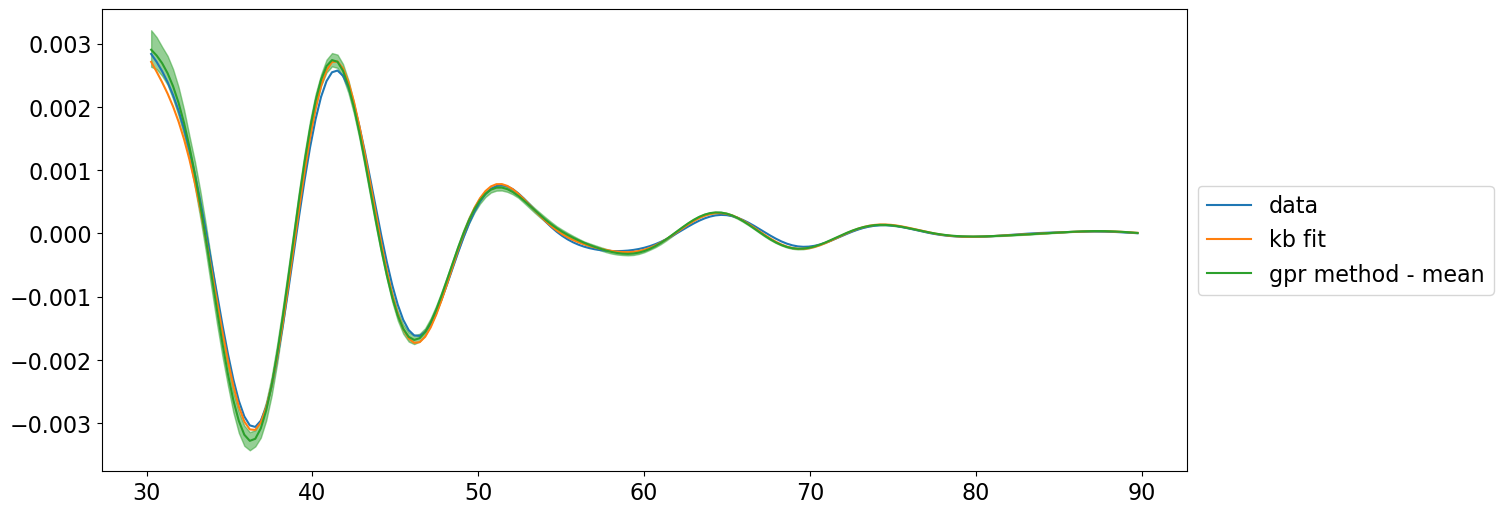

In [825]:
plt.figure(figsize=(14,6))
plt.plot(fr_32.userkws['x'], fr_32.data.imag, label='data')
plt.plot(fr_32.userkws['x'], fr_32.eval().imag, label='kb fit')

plt.plot(fr_32_copy.userkws['x'], new_32_preds.imag.T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=new_32_preds.imag.T.min(1), y2=new_32_preds.imag.T.max(1), color='C2', alpha=0.5)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

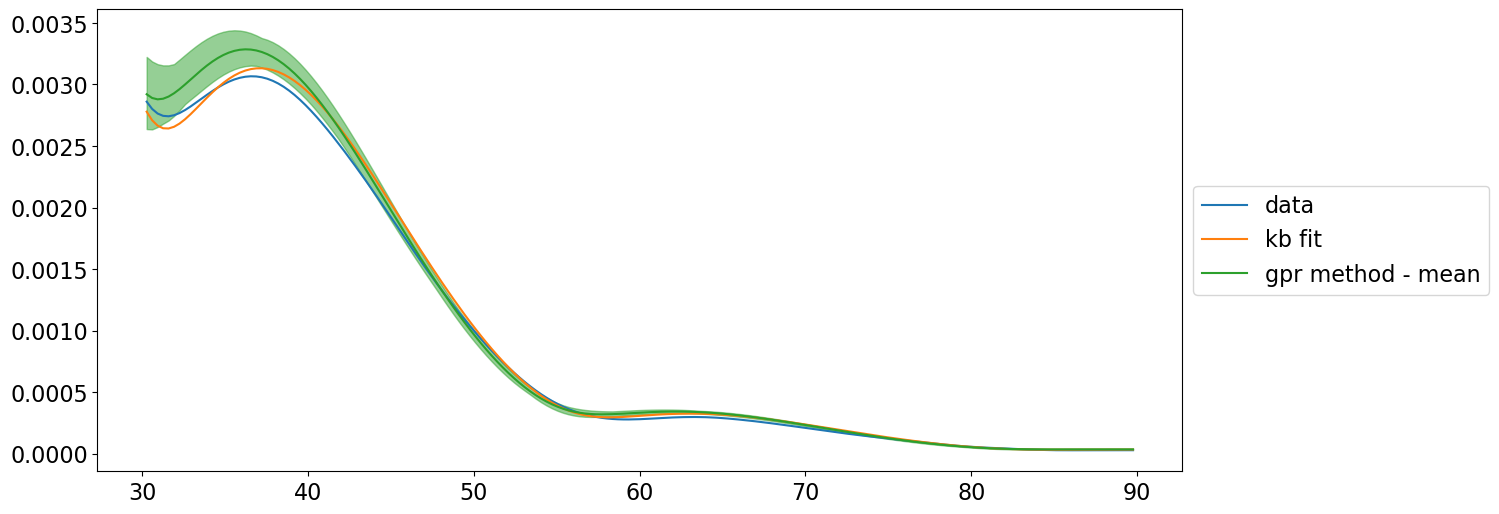

In [826]:
plt.figure(figsize=(14,6))
plt.plot(fr_32.userkws['x'], np.abs(fr_32.data), label='data')
plt.plot(fr_32.userkws['x'], np.abs(fr_32.eval()), label='kb fit')

plt.plot(fr_32_copy.userkws['x'], np.abs(new_32_preds.T).mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=np.abs(new_32_preds.T).min(1), y2=np.abs(new_32_preds.T).max(1), color='C2', alpha=0.5)

# plt.plot(fr_32_copy.userkws['x'], np.abs(new_32_preds.T), c='C2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

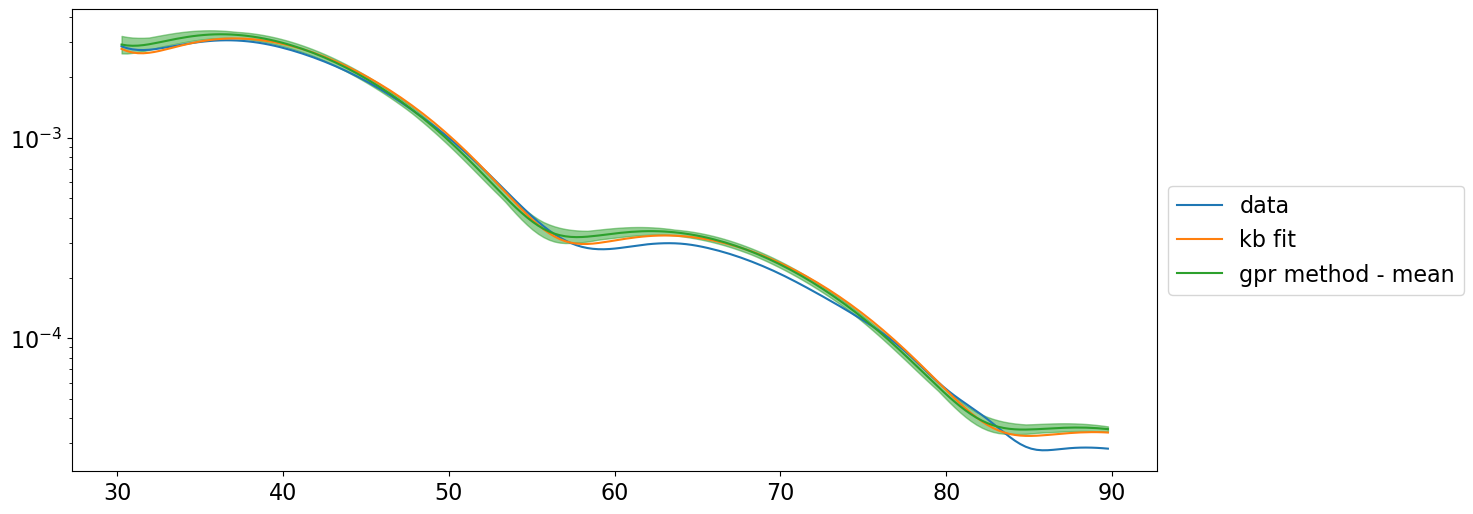

In [827]:
plt.figure(figsize=(14,6))
plt.plot(fr_32.userkws['x'], np.abs(fr_32.data), label='data')
plt.plot(fr_32.userkws['x'], np.abs(fr_32.eval()), label='kb fit')

plt.plot(fr_32_copy.userkws['x'], np.abs(new_32_preds.T).mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=np.abs(new_32_preds.T).min(1), y2=np.abs(new_32_preds.T).max(1), color='C2', alpha=0.5)

# plt.plot(fr_32_copy.userkws['x'], np.abs(new_32_preds.T), c='C2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

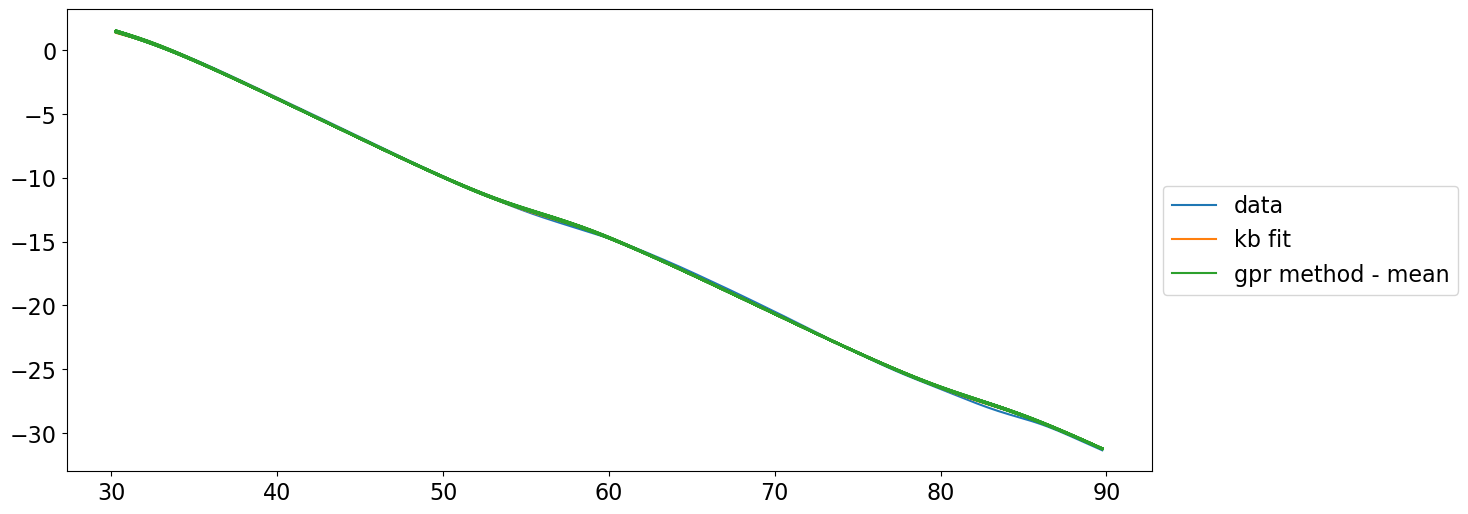

In [828]:
plt.figure(figsize=(14,6))
plt.plot(fr_32.userkws['x'], np.unwrap(np.angle(fr_32.data)), label='data')
plt.plot(fr_32.userkws['x'], np.unwrap(np.angle(fr_32.eval())), label='kb fit')

plt.plot(fr_32_copy.userkws['x'], np.unwrap(np.angle(new_32_preds)).T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=np.unwrap(np.angle(new_32_preds)).T.min(1), y2=np.unwrap(np.angle(new_32_preds)).T.max(1), color='C2', alpha=0.5)

plt.plot(fr_32_copy.userkws['x'], np.unwrap(np.angle(new_32_preds)).T, c='C2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

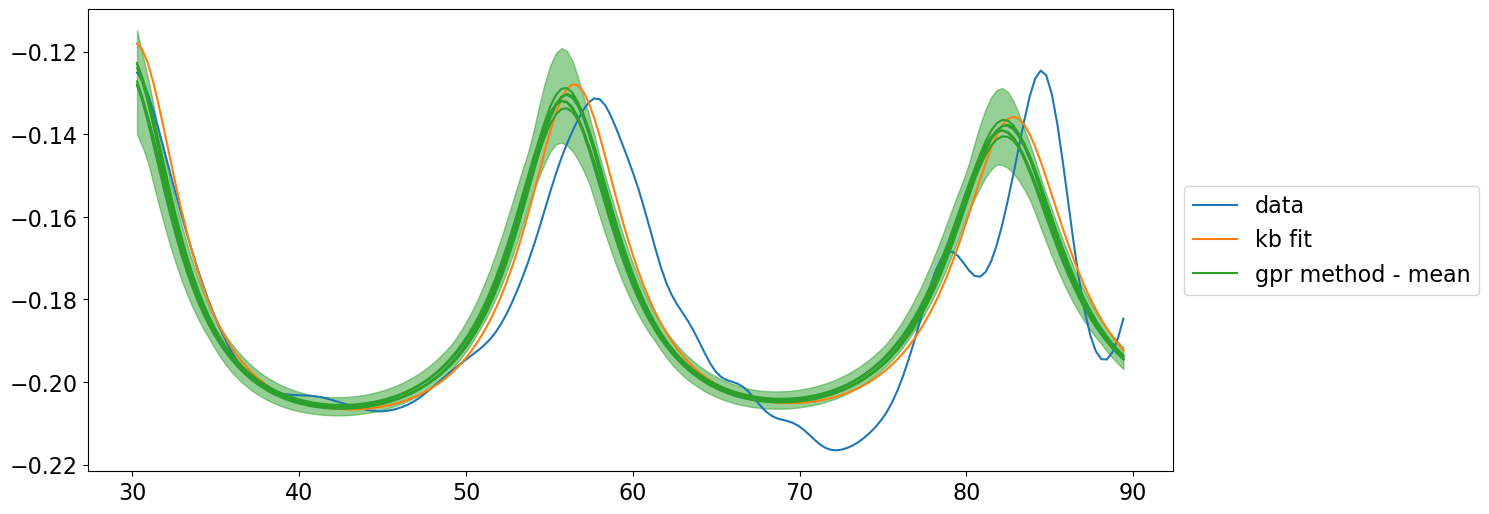

In [829]:
plt.figure(figsize=(14,6))
plt.plot(fr_32.userkws['x'][:-1], np.diff(np.unwrap(np.angle(fr_32.data))), label='data')
plt.plot(fr_32.userkws['x'][:-1], np.diff(np.unwrap(np.angle(fr_32.eval()))), label='kb fit')

plt.plot(fr_32_copy.userkws['x'][:-1], np.diff(np.unwrap(np.angle(new_32_preds))).T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'][:-1], y1=np.diff(np.unwrap(np.angle(new_32_preds))).T.min(1), y2=np.diff(np.unwrap(np.angle(new_32_preds))).T.max(1), color='C2', alpha=0.5)

plt.plot(fr_32_copy.userkws['x'][:-1], np.diff(np.unwrap(np.angle(new_32_preds))).T[:,:5], c='C2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

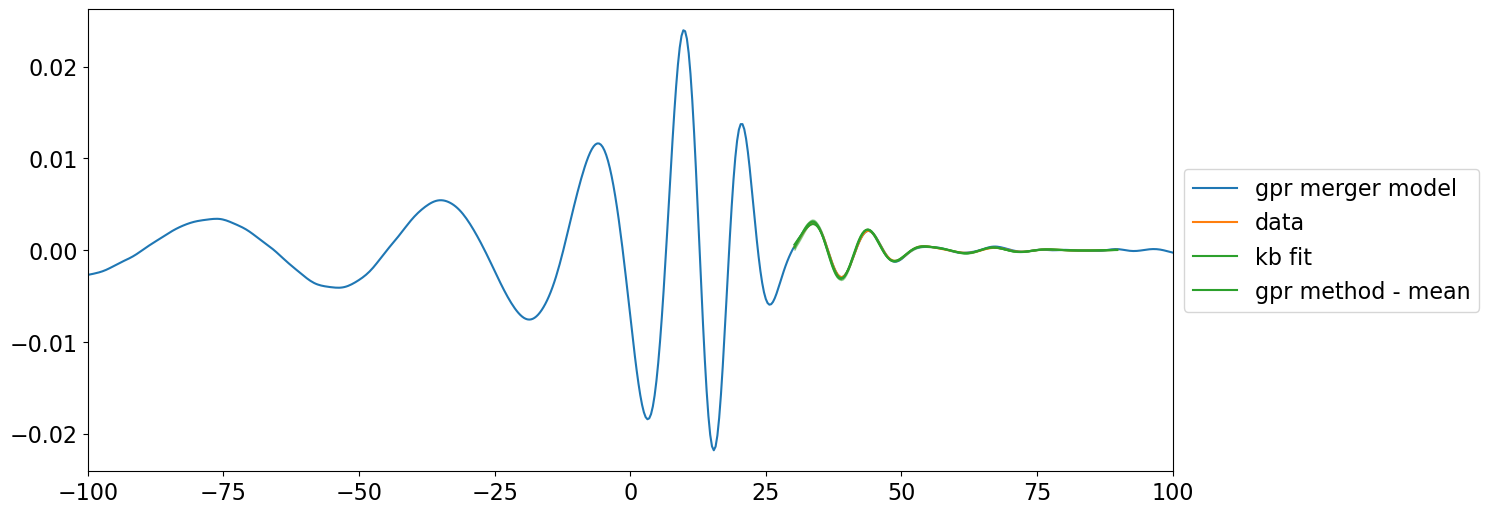

In [830]:

plt.figure(figsize=(14,6))

plt.plot(t_, yhat32_z[:,0].real, label='gpr merger model')
plt.plot(fr_32.userkws['x'], fr_32.data.real, label='data')
plt.plot(fr_32.userkws['x'], fr_32.eval().real, label='kb fit')
plt.plot(fr_32_copy.userkws['x'], new_32_preds.real.T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=new_32_preds.real.T.min(1), y2=new_32_preds.real.T.max(1), color='C2', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlim(-100, 100)

(-100.0, 100.0)

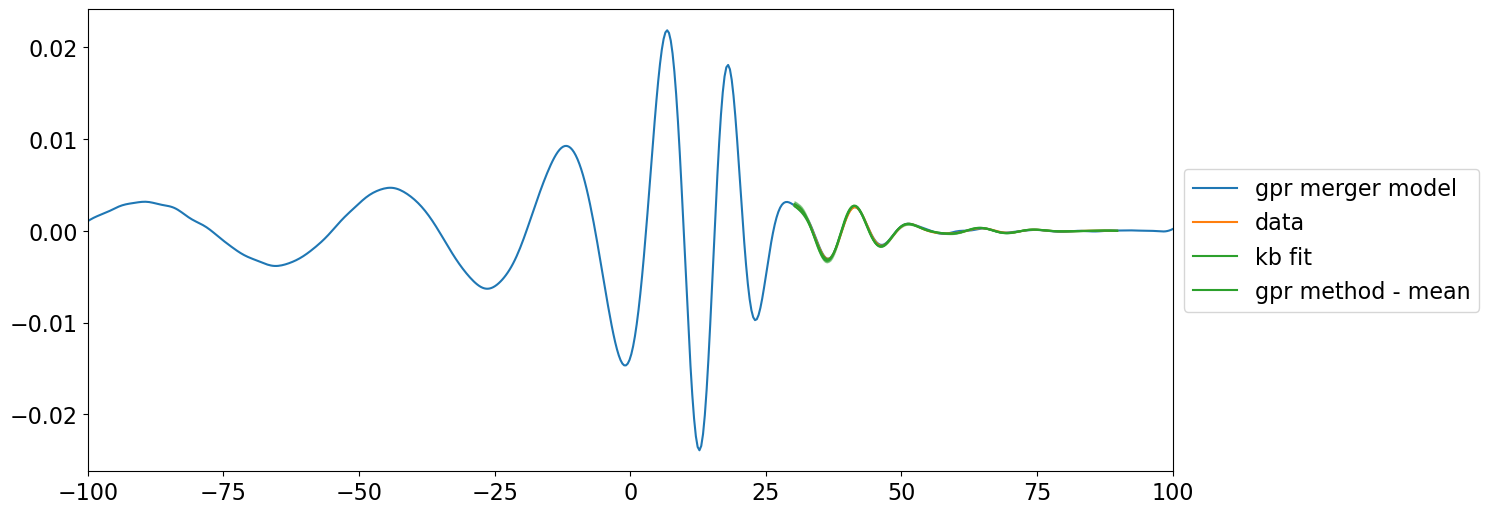

In [831]:

plt.figure(figsize=(14,6))

plt.plot(t_, yhat32_z[:,0].imag, label='gpr merger model')
plt.plot(fr_32.userkws['x'], fr_32.data.imag, label='data')
plt.plot(fr_32.userkws['x'], fr_32.eval().imag, label='kb fit')
plt.plot(fr_32_copy.userkws['x'], new_32_preds.imag.T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'], y1=new_32_preds.imag.T.min(1), y2=new_32_preds.imag.T.max(1), color='C2', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlim(-100, 100)

In [848]:
t_.shape

(1211,)

In [853]:
np.diff(yhat32_z).shape

(1211, 99)

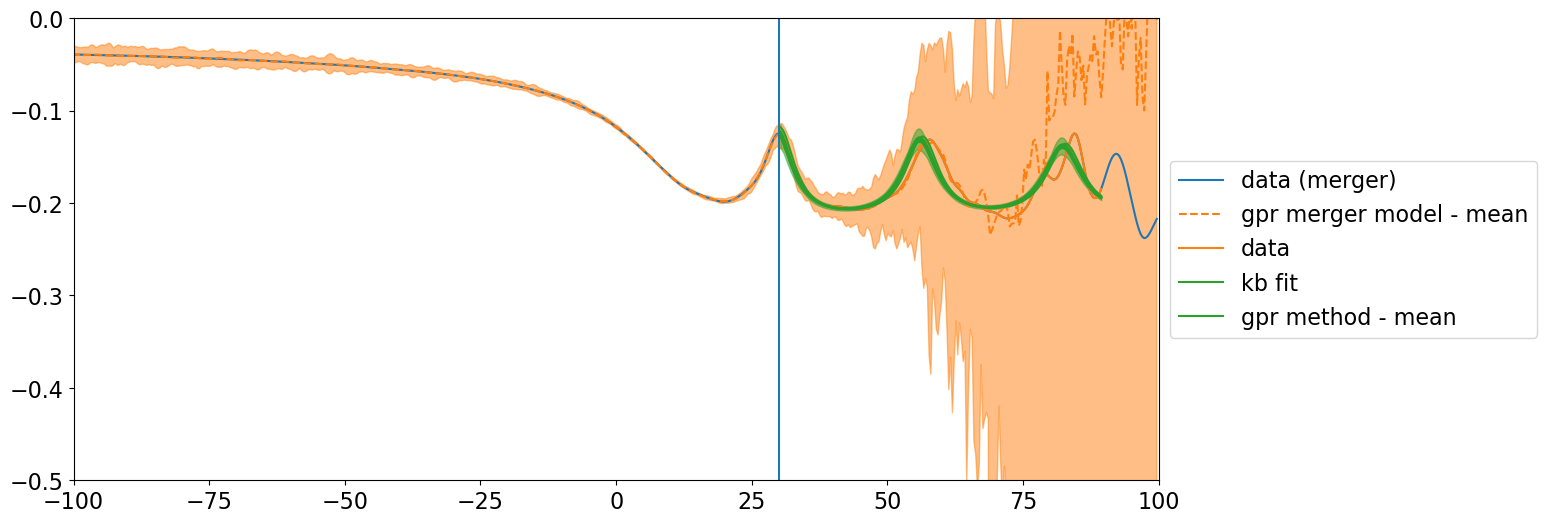

In [863]:
plt.figure(figsize=(14,6))


plt.plot(wf.times[:-1], np.diff(np.unwrap(np.angle(wf.hlms[3,2]))), label='data (merger)')
plt.plot(t_[:-1], np.diff(np.unwrap(np.angle(yhat32_z.T))).T.mean(1), label='gpr merger model - mean', ls='--', c='C1')

plt.fill_between(t_[:-1], y1=np.diff(np.unwrap(np.angle(yhat32_z.T))).T.min(1), y2=np.diff(np.unwrap(np.angle(yhat32_z.T))).T.max(1), color='C1', alpha=0.5)

plt.plot(fr_32.userkws['x'][:-1], np.diff(np.unwrap(np.angle(fr_32.data))), label='data')
plt.plot(fr_32.userkws['x'][:-1], np.diff(np.unwrap(np.angle(fr_32.eval()))), label='kb fit')

plt.plot(fr_32_copy.userkws['x'][:-1], np.diff(np.unwrap(np.angle(new_32_preds))).T.mean(1), label='gpr method - mean', c='C2')
plt.fill_between(fr_32_copy.userkws['x'][:-1], y1=np.diff(np.unwrap(np.angle(new_32_preds))).T.min(1), y2=np.diff(np.unwrap(np.angle(new_32_preds))).T.max(1), color='C2', alpha=0.5)

plt.plot(fr_32_copy.userkws['x'][:-1], np.diff(np.unwrap(np.angle(new_32_preds))).T[:,:5], c='C2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlim(-100, 100)
plt.ylim(-0.5, 0.)

plt.axvline(30)